# JND Frequency Analysis: Age Effect

This notebook analyzes the effect of Age Group (Old vs. Young) on JND frequency under four different conditions:
1. Frequency 500Hz, ISI 1000ms
2. Frequency 500Hz, ISI 100ms
3. Frequency 3000Hz, ISI 1000ms
4. Frequency 3000Hz, ISI 100ms

## Methodology
1. **Data Loading**: Load the summary data processed from individual CSV files.
2. **Preprocessing**: Filter outliers using the IQR (Interquartile Range) method.
3. **Statistical Analysis**:
    - Check for Normality (Shapiro-Wilk test).
    - If normal: Independent T-test.
    - If not normal: Mann-Whitney U test.
4. **Visualization**: Boxplots with stripplots to show individual data points.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set visual style
sns.set_style("whitegrid")
# Use DejaVu Sans which is commonly available on most systems
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'DejaVuSans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# Load Data
file_path = '/media/folks/Windows/mpc_new_data/jnd_summary.csv'
df = pd.read_csv(file_path)

print("Data Head:")
display(df.head())
print("\nData Info:")
print(df.info())
print("\nGroup Counts:")
print(df['Group'].value_counts())

Data Head:


,filename,Subj_ID,Group,JND_500_1000,JND_500_100,JND_3000_1000,JND_3000_100
0,jnd_experiment_001.csv,1,Old,20,32,128,96
1,jnd_experiment_002.csv,2,Old,16,24,48,64
2,jnd_experiment_003.csv,3,Old,32,28,64,112
3,jnd_experiment_004.csv,4,Old,4,8,16,44
4,jnd_experiment_005.csv,5,Old,20,20,52,80



Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   filename       24 non-null     str  
 1   Subj_ID        24 non-null     str  
 2   Group          24 non-null     str  
 3   JND_500_1000   24 non-null     int64
 4   JND_500_100    24 non-null     int64
 5   JND_3000_1000  24 non-null     int64
 6   JND_3000_100   24 non-null     int64
dtypes: int64(4), str(3)
memory usage: 1.4 KB
None

Group Counts:
Group
Old      13
Young    11
Name: count, dtype: int64


In [4]:
def remove_outliers_iqr(df_in, column, group_col):
    """
    Removes outliers from a dataframe based on IQR, calculated separately for each group.
    """
    df_clean = df_in.copy()
    indices_to_drop = []
    
    unique_groups = df_in[group_col].dropna().unique()
    
    for group in unique_groups:
        # Get data for this group
        group_mask = df_in[group_col] == group
        group_data = df_in.loc[group_mask, column]
        
        if len(group_data) < 4:
            continue # Skip outlier detection for very small samples
            
        Q1 = group_data.quantile(0.25)
        Q3 = group_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = group_data[(group_data < lower_bound) | (group_data > upper_bound)]
        current_indices = outliers.index.tolist()
        indices_to_drop.extend(current_indices)
        
        if len(outliers) > 0:
            print(f"[{group}] Column '{column}': Dropped {len(outliers)} outliers (Indices: {current_indices}, Values: {outliers.values})")
            
    return df_clean.drop(indices_to_drop)

def analyze_and_plot(df_input, value_col, group_col='Group', condition_name=None):
    """
    Comprehensive analysis with detailed statistics and enhanced visualization.
    """
    print(f"\n{'='*80}")
    print(f"Analyzing Condition: {condition_name if condition_name else value_col}")
    print(f"{'='*80}")
    
    # 1. Remove Outliers
    df_clean = remove_outliers_iqr(df_input, value_col, group_col)
    print(f"Original sample size: {len(df_input)}, Cleaned sample size: {len(df_clean)}")
    
    # 2. Get groups
    group_labels = sorted(df_clean[group_col].unique())
    groups = [df_clean[df_clean[group_col] == g][value_col] for g in group_labels]
    
    # 3. Descriptive Statistics
    print("\n## Descriptive Statistics")
    stats_data = []
    for i, g_label in enumerate(group_labels):
        g_data = groups[i]
        stats_data.append({
            'Age Group': g_label,
            'N': len(g_data),
            'Mean': f"{g_data.mean():.2f}",
            'SD': f"{g_data.std():.2f}",
            'Median': f"{g_data.median():.2f}",
            'Min': f"{g_data.min():.0f}",
            'Max': f"{g_data.max():.0f}"
        })
        print(f"  {g_label}: N={len(g_data)}, Mean={g_data.mean():.2f}±{g_data.std():.2f}, Median={g_data.median():.2f}")
    
    stats_df = pd.DataFrame(stats_data)
    
    # 4. Normality Test (Shapiro-Wilk)
    print("\n## Normality Test (Shapiro-Wilk)")
    is_normal = True
    normality_results = []
    for i, g_data in enumerate(groups):
        if len(g_data) < 3:
            print(f"  {group_labels[i]}: Sample size too small (n={len(g_data)}), skipping test")
            is_normal = False
            normality_results.append({'Group': group_labels[i], 'Test': 'Shapiro-Wilk', 'W Statistic': 'N/A', 'P-value': 'N/A', 'Normal': 'Not tested'})
        else:
            stat, p = stats.shapiro(g_data)
            normal = 'Yes' if p > 0.05 else 'No'
            print(f"  {group_labels[i]}: W={stat:.4f}, p={p:.4f} ({'Normal' if p > 0.05 else 'Non-normal'})")
            normality_results.append({'Group': group_labels[i], 'Test': 'Shapiro-Wilk', 'W Statistic': f"{stat:.4f}", 'P-value': f"{p:.4f}", 'Normal': normal})
            if p < 0.05:
                is_normal = False
    
    normality_df = pd.DataFrame(normality_results)
    
    # 5. Statistical Test with detailed parameters
    print("\n## Statistical Test")
    test_results = {}
    try:
        if is_normal:
            # Independent T-test
            stat, p = stats.ttest_ind(*groups)
            test_name = "Independent T-test"
            test_results['Test Method'] = test_name
            test_results['Statistic'] = f"{stat:.4f}"
            test_results['P-value'] = f"{p:.6f}"
            test_results['Sample 1 Mean'] = f"{groups[0].mean():.2f}"
            test_results['Sample 2 Mean'] = f"{groups[1].mean():.2f}"
            test_results['Sample 1 SD'] = f"{groups[0].std():.2f}"
            test_results['Sample 2 SD'] = f"{groups[1].std():.2f}"
            test_results['df'] = len(df_clean) - 2
            print(f"  Method: {test_name}")
            print(f"  Parameters: {group_labels[0]} Mean={groups[0].mean():.2f}±{groups[0].std():.2f}, {group_labels[1]} Mean={groups[1].mean():.2f}±{groups[1].std():.2f}")
            print(f"  Statistic: t({len(df_clean)-2})={stat:.4f}, p={p:.6f}")
        else:
            # Mann-Whitney U Test
            stat, p = stats.mannwhitneyu(*groups)
            test_name = "Mann-Whitney U Test (Non-parametric)"
            test_results['Test Method'] = test_name
            test_results['Statistic'] = f"{stat:.4f}"
            test_results['P-value'] = f"{p:.6f}"
            test_results['Sample 1 Median'] = f"{groups[0].median():.2f}"
            test_results['Sample 2 Median'] = f"{groups[1].median():.2f}"
            test_results['Sample 1 N'] = len(groups[0])
            test_results['Sample 2 N'] = len(groups[1])
            print(f"  Method: {test_name}")
            print(f"  Parameters: {group_labels[0]} Median={groups[0].median():.2f} (n={len(groups[0])}), {group_labels[1]} Median={groups[1].median():.2f} (n={len(groups[1])})")
            print(f"  Statistic: U={stat:.4f}, p={p:.6f}")
        
        # Significance interpretation
        significance = ""
        if p < 0.001:
            significance = "*** (p < 0.001)"
        elif p < 0.01:
            significance = "** (p < 0.01)"
        elif p < 0.05:
            significance = "* (p < 0.05)"
        else:
            significance = "ns (p ≥ 0.05)"
        
        test_results['Significance'] = significance
        print(f"  Conclusion: {significance}")
        
    except Exception as e:
        print(f"  Error: {e}")
        p = 1.0
        test_name = "Error"
        test_results['Test Method'] = 'Error'
        test_results['Significance'] = 'Error'

    # 6. Enhanced Plotting
    try:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Boxplot with stripplot
        ax1 = axes[0]
        sns.boxplot(x=group_col, y=value_col, data=df_clean, hue=group_col, palette="Set2", showfliers=False, order=group_labels, legend=False, ax=ax1)
        sns.stripplot(x=group_col, y=value_col, data=df_clean, color='black', alpha=0.6, jitter=True, order=group_labels, ax=ax1, size=8)
        ax1.set_title(f'{condition_name if condition_name else value_col}\n({test_name})', fontsize=12, fontweight='bold')
        ax1.set_ylabel('JND (Hz)', fontsize=11)
        ax1.set_xlabel('Age Group', fontsize=11)
        ax1.grid(True, axis='y', alpha=0.3)
        
        # Add p-value annotation
        y_max = df_clean[value_col].max()
        y_min = df_clean[value_col].min()
        y_range = y_max - y_min
        ax1.text(0.5, y_max + y_range*0.05, f'p={p:.4f} {significance.split("(")[0]}', 
                ha='center', fontsize=10, fontweight='bold')
        
        # Plot 2: Violin plot
        ax2 = axes[1]
        sns.violinplot(x=group_col, y=value_col, data=df_clean, hue=group_col, palette="Set2", order=group_labels, legend=False, ax=ax2)
        sns.stripplot(x=group_col, y=value_col, data=df_clean, color='black', alpha=0.4, jitter=True, order=group_labels, ax=ax2, size=6)
        ax2.set_title(f'Distribution Comparison - {condition_name if condition_name else value_col}', fontsize=12, fontweight='bold')
        ax2.set_ylabel('JND (Hz)', fontsize=11)
        ax2.set_xlabel('Age Group', fontsize=11)
        ax2.grid(True, axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Plotting Error: {e}")
    
    return {
        'condition': condition_name if condition_name else value_col,
        'stats': stats_df,
        'normality': normality_df,
        'test_results': test_results,
        'p_value': p,
        'df_clean': df_clean
    }

# Store results for summary table
all_results = {}


Analyzing Condition: Frequency 500Hz, ISI 1000ms
[Old] Column 'JND_500_1000': Dropped 1 outliers (Indices: [3], Values: [4])
Original sample size: 24, Cleaned sample size: 23

## Descriptive Statistics
  Old: N=12, Mean=20.58±6.75, Median=18.00
  Young: N=11, Mean=14.55±6.55, Median=16.00

## Normality Test (Shapiro-Wilk)
  Old: W=0.8544, p=0.0416 (Non-normal)
  Young: W=0.8094, p=0.0125 (Non-normal)

## Statistical Test
  Method: Mann-Whitney U Test (Non-parametric)
  Parameters: Old Median=18.00 (n=12), Young Median=16.00 (n=11)
  Statistic: U=90.0000, p=0.136216
  Conclusion: ns (p ≥ 0.05)


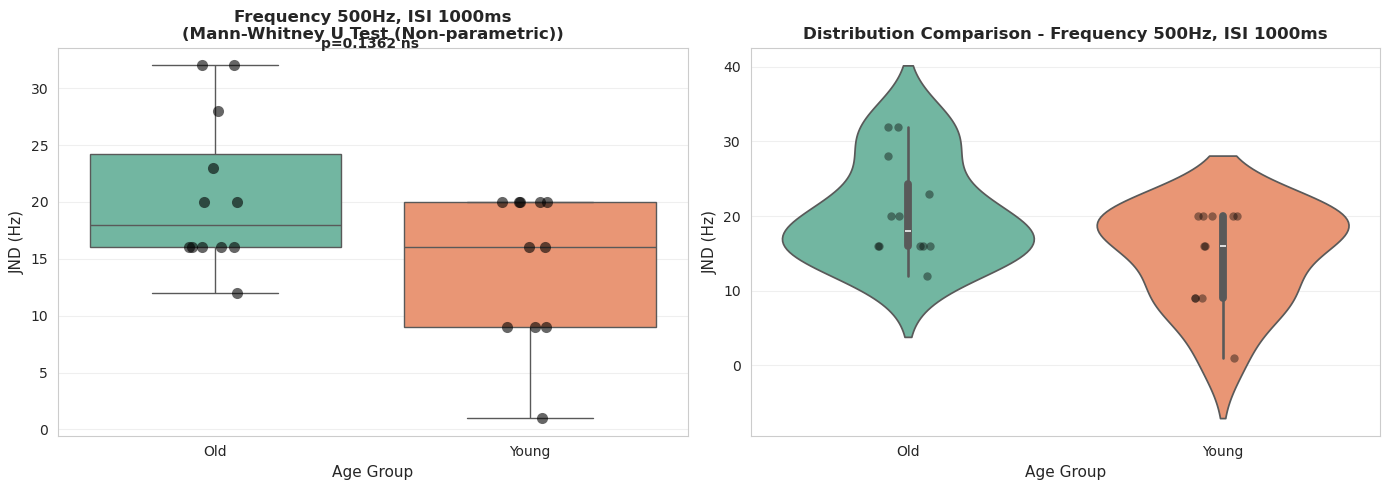


Analyzing Condition: Frequency 500Hz, ISI 100ms
[Young] Column 'JND_500_100': Dropped 2 outliers (Indices: [14, 22], Values: [1 1])
Original sample size: 24, Cleaned sample size: 22

## Descriptive Statistics
  Old: N=13, Mean=19.77±8.35, Median=20.00
  Young: N=9, Mean=18.33±3.87, Median=20.00

## Normality Test (Shapiro-Wilk)
  Old: W=0.9547, p=0.6716 (Normal)
  Young: W=0.8546, p=0.0836 (Normal)

## Statistical Test
  Method: Independent T-test
  Parameters: Old Mean=19.77±8.35, Young Mean=18.33±3.87
  Statistic: t(20)=0.4789, p=0.637222
  Conclusion: ns (p ≥ 0.05)


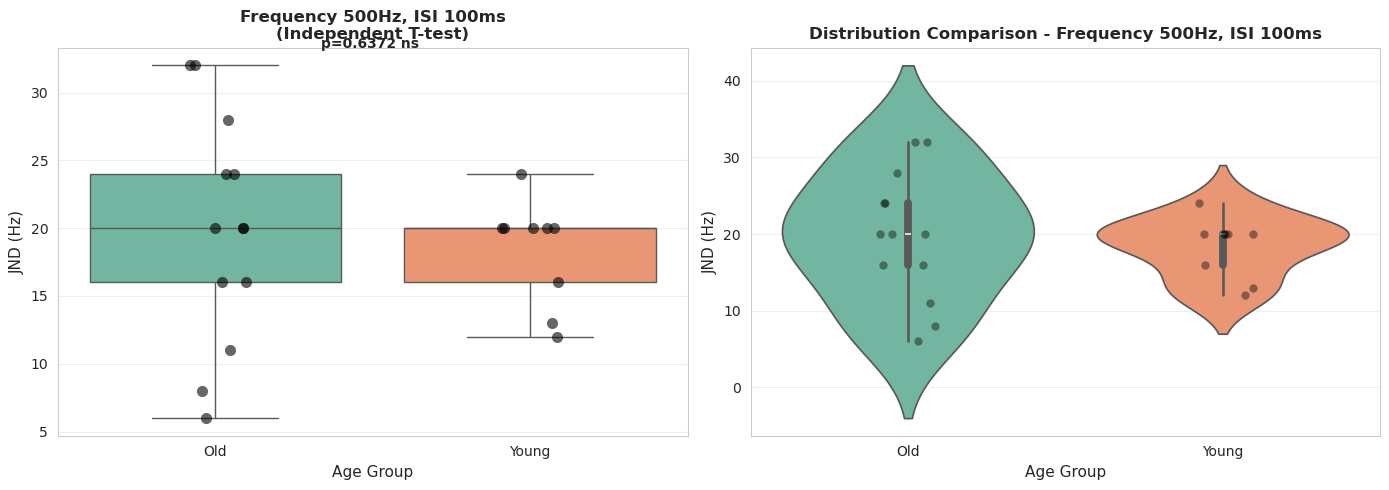


Analyzing Condition: Frequency 3000Hz, ISI 1000ms
Original sample size: 24, Cleaned sample size: 24

## Descriptive Statistics
  Old: N=13, Mean=92.62±46.87, Median=80.00
  Young: N=11, Mean=57.09±28.51, Median=64.00

## Normality Test (Shapiro-Wilk)
  Old: W=0.9201, p=0.2520 (Normal)
  Young: W=0.8991, p=0.1801 (Normal)

## Statistical Test
  Method: Independent T-test
  Parameters: Old Mean=92.62±46.87, Young Mean=57.09±28.51
  Statistic: t(22)=2.1899, p=0.039422
  Conclusion: * (p < 0.05)


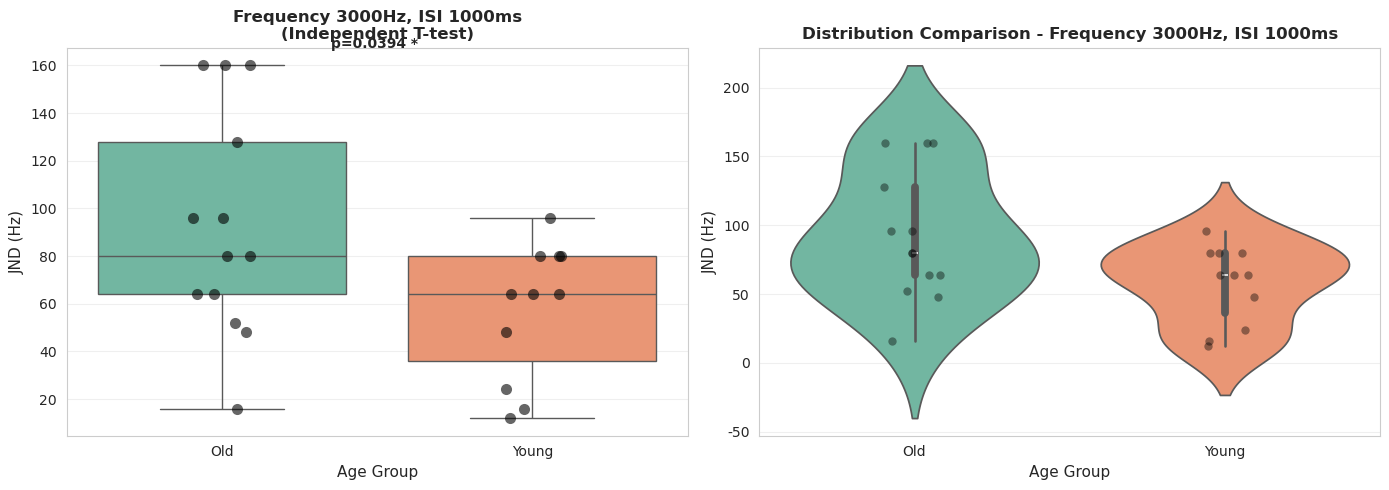


Analyzing Condition: Frequency 3000Hz, ISI 100ms
[Old] Column 'JND_3000_100': Dropped 2 outliers (Indices: [3, 12], Values: [ 44 144])
Original sample size: 24, Cleaned sample size: 22

## Descriptive Statistics
  Old: N=11, Mean=85.09±12.91, Median=80.00
  Young: N=11, Mean=64.36±30.85, Median=68.00

## Normality Test (Shapiro-Wilk)
  Old: W=0.9053, p=0.2144 (Normal)
  Young: W=0.9458, p=0.5911 (Normal)

## Statistical Test
  Method: Independent T-test
  Parameters: Old Mean=85.09±12.91, Young Mean=64.36±30.85
  Statistic: t(20)=2.0555, p=0.053126
  Conclusion: ns (p ≥ 0.05)


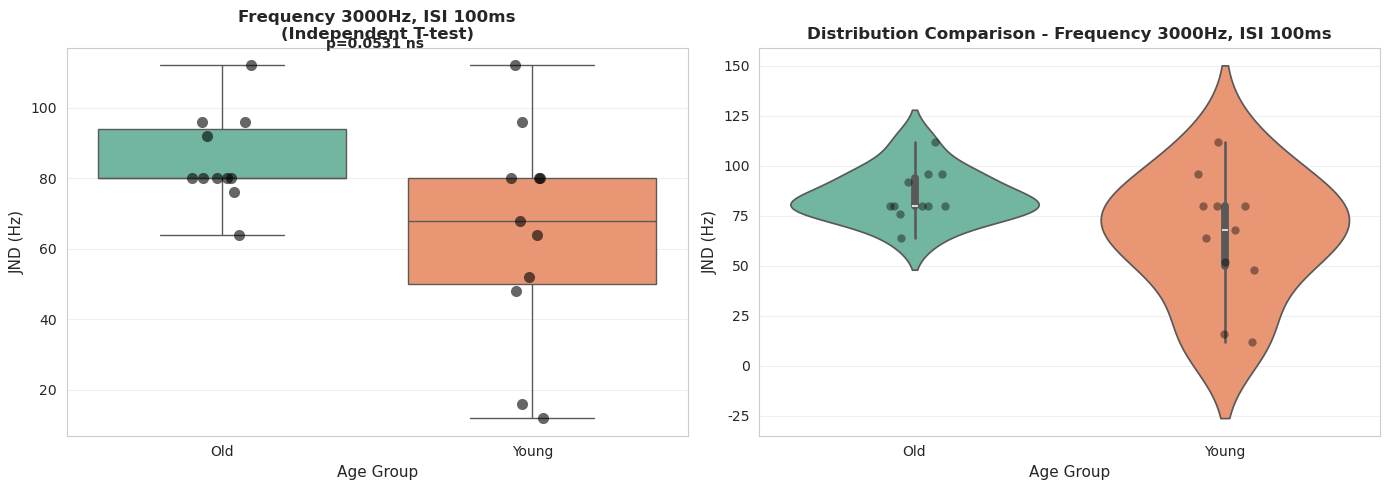

In [5]:
# Run analysis for all 4 conditions
conditions = {
    'JND_500_1000': 'Frequency 500Hz, ISI 1000ms',
    'JND_500_100': 'Frequency 500Hz, ISI 100ms',
    'JND_3000_1000': 'Frequency 3000Hz, ISI 1000ms',
    'JND_3000_100': 'Frequency 3000Hz, ISI 100ms'
}

for col_name, condition_name in conditions.items():
    result = analyze_and_plot(df, col_name, condition_name=condition_name)
    all_results[condition_name] = result

In [6]:
# Statistical Test Results Summary
print("\n" + "="*100)
print("Statistical Test Results Summary")
print("="*100 + "\n")

summary_data = []
for condition, result in all_results.items():
    summary_data.append({
        'Condition': condition,
        'Test Method': result['test_results'].get('Test Method', 'N/A'),
        'Statistic': result['test_results'].get('Statistic', 'N/A'),
        'P-value': result['test_results'].get('P-value', 'N/A'),
        'Significance': result['test_results'].get('Significance', 'N/A')
    })

summary_table = pd.DataFrame(summary_data)
display(summary_table)

print("\nSignificance Markers: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05")


Statistical Test Results Summary



,Condition,Test Method,Statistic,P-value,Significance
0,"Frequency 500Hz, ISI 1000ms",Mann-Whitney U Test (Non-parametric),90.0000,0.136216,ns (p ≥ 0.05)
1,"Frequency 500Hz, ISI 100ms",Independent T-test,0.4789,0.637222,ns (p ≥ 0.05)
2,"Frequency 3000Hz, ISI 1000ms",Independent T-test,2.1899,0.039422,* (p < 0.05)
3,"Frequency 3000Hz, ISI 100ms",Independent T-test,2.0555,0.053126,ns (p ≥ 0.05)



Significance Markers: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05


In [12]:
# Multi-factorial Analysis: Data Preparation and ANOVA Calculations
print("\n" + "="*100)
print("## Multi-factorial Analysis: Frequency × ISI × Age Group")
print("="*100 + "\n")

# Prepare data for multifactorial analysis
df_analysis = df.copy()

# Melt the data to long format
value_vars = ['JND_500_1000', 'JND_500_100', 'JND_3000_1000', 'JND_3000_100']
df_long = pd.melt(df_analysis, id_vars=['Subj_ID', 'Group'], 
                   value_vars=value_vars, var_name='Condition', value_name='JND')

# Extract frequency and ISI from condition names
df_long['Frequency'] = df_long['Condition'].str.extract(r'(\d{3,4})')[0].astype(int)
df_long['ISI'] = df_long['Condition'].str.extract(r'_(\d+)$')[0].astype(int)
df_long = df_long.drop('Condition', axis=1)

# Remove outliers from combined data
df_long_clean = df_long.copy()
outlier_indices = set()

# Remove outliers per group and frequency/ISI combination
for group in df_long['Group'].unique():
    for freq in df_long['Frequency'].unique():
        for isi in df_long['ISI'].unique():
            mask = (df_long['Group'] == group) & (df_long['Frequency'] == freq) & (df_long['ISI'] == isi)
            subset = df_long[mask]['JND']
            
            if len(subset) < 4:
                continue
                
            Q1 = subset.quantile(0.25)
            Q3 = subset.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            
            outlier_indices.update(subset[(subset < lower) | (subset > upper)].index)

df_long_clean = df_long.drop(list(outlier_indices))

print(f"Multi-factorial analysis sample: Original={len(df_long)}, Cleaned={len(df_long_clean)}")

# Import statsmodels for ANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import itertools

print("\n## Comprehensive Multi-way ANOVA Analysis")
print("\n" + "="*100)
print("### ANOVA Analysis 1: Frequency × Age Group")
print("="*100)

# Prepare data for ANOVA: Frequency (500, 3000) × Age Group (Old, Young)
df_anova_1 = df_long_clean[df_long_clean['ISI'] == 1000].copy()
model_1 = ols('JND ~ C(Frequency) + C(Group) + C(Frequency):C(Group)', data=df_anova_1).fit()
anova_table_1 = anova_lm(model_1, typ=2)
print("\nTable: 2-way ANOVA - Frequency × Age Group (ISI=1000ms)")
print(anova_table_1)

# Summary statistics
print("\nGroupwise Means (ISI=1000ms):")
groupwise_1 = df_anova_1.groupby(['Frequency', 'Group'])['JND'].agg(['mean', 'std', 'count'])
print(groupwise_1)

print("\n" + "="*100)
print("### ANOVA Analysis 2: ISI × Age Group")
print("="*100)

# Prepare data for ANOVA: ISI (100, 1000) × Age Group (Old, Young)
df_anova_2 = df_long_clean[df_long_clean['Frequency'] == 3000].copy()
model_2 = ols('JND ~ C(ISI) + C(Group) + C(ISI):C(Group)', data=df_anova_2).fit()
anova_table_2 = anova_lm(model_2, typ=2)
print("\nTable: 2-way ANOVA - ISI × Age Group (Frequency=3000Hz)")
print(anova_table_2)

# Summary statistics
print("\nGroupwise Means (Frequency=3000Hz):")
groupwise_2 = df_anova_2.groupby(['ISI', 'Group'])['JND'].agg(['mean', 'std', 'count'])
print(groupwise_2)

print("\n" + "="*100)
print("### ANOVA Analysis 3: Frequency × ISI × Age Group (Three-way ANOVA)")
print("="*100)

# Three-way ANOVA
model_3 = ols('JND ~ C(Frequency) + C(ISI) + C(Group) + C(Frequency):C(ISI) + C(Frequency):C(Group) + C(ISI):C(Group) + C(Frequency):C(ISI):C(Group)', 
              data=df_long_clean).fit()
anova_table_3 = anova_lm(model_3, typ=2)
print("\nTable: 3-way ANOVA - Frequency × ISI × Age Group")
print(anova_table_3)

# Summary statistics for all combinations
print("\nGroupwise Means (All Combinations):")
groupwise_3 = df_long_clean.groupby(['Frequency', 'ISI', 'Group'])['JND'].agg(['mean', 'std', 'count'])
print(groupwise_3)

# Prepare reset versions for plotting
groupwise_1_reset = groupwise_1.reset_index()
groupwise_2_reset = groupwise_2.reset_index()
groupwise_3_pivot = groupwise_3.reset_index()

print("\n✓ ANOVA calculations complete. Ready for visualization.")


## Multi-factorial Analysis: Frequency × ISI × Age Group

Multi-factorial analysis sample: Original=96, Cleaned=91

## Comprehensive Multi-way ANOVA Analysis

### ANOVA Analysis 1: Frequency × Age Group

Table: 2-way ANOVA - Frequency × Age Group (ISI=1000ms)
                             sum_sq    df          F        PR(>F)
C(Frequency)           39790.878228   1.0  48.301311  1.520672e-08
C(Group)                5186.848400   1.0   6.296206  1.594728e-02
C(Frequency):C(Group)   2541.724546   1.0   3.085346  8.612038e-02
Residual               35423.629953  43.0        NaN           NaN

Groupwise Means (ISI=1000ms):
                      mean        std  count
Frequency Group                             
500       Old    20.583333   6.748176     12
          Young  14.545455   6.547727     11
3000      Old    92.615385  46.871346     13
          Young  57.090909  28.514749     11

### ANOVA Analysis 2: ISI × Age Group

Table: 2-way ANOVA - ISI × Age Group (Frequency=3000Hz)
       

## Figure 1: ANOVA Results Tables

### What to Look For:

**Table Components:**
- **Index**: Factor or interaction term names
  - `C(Frequency)`: Frequency factor (500Hz vs 3000Hz)
  - `C(Group)`: Age group factor (Old vs Young)
  - `C(ISI)`: ISI factor (100ms vs 1000ms)
  - `Frequency:Group`, etc.: Interaction effects
  
- **sum_sq** (Sum of Squares): Total amount of variance explained by each factor
  - Larger value = Stronger factor effect
  
- **df** (Degrees of Freedom): Number of independent comparisons
  
- **F** (F-statistic): Between-group variance / Within-group variance
  - Larger value = Stronger factor effect
  
- **PR(>F)** (p-value): Statistical significance
  - **Yellow cells** = p < 0.05 (significant)
  - Smaller value = More likely to be a real effect rather than random

### How to Interpret:
1. Check yellow highlighted cells (p < 0.05) = Significant effects
2. Compare F values: Larger F indicates stronger factor impact on JND
3. Focus on interaction terms (e.g., `Frequency:Group`) to understand if different age groups respond differently to factors


## Figure 1: ANOVA Results Tables



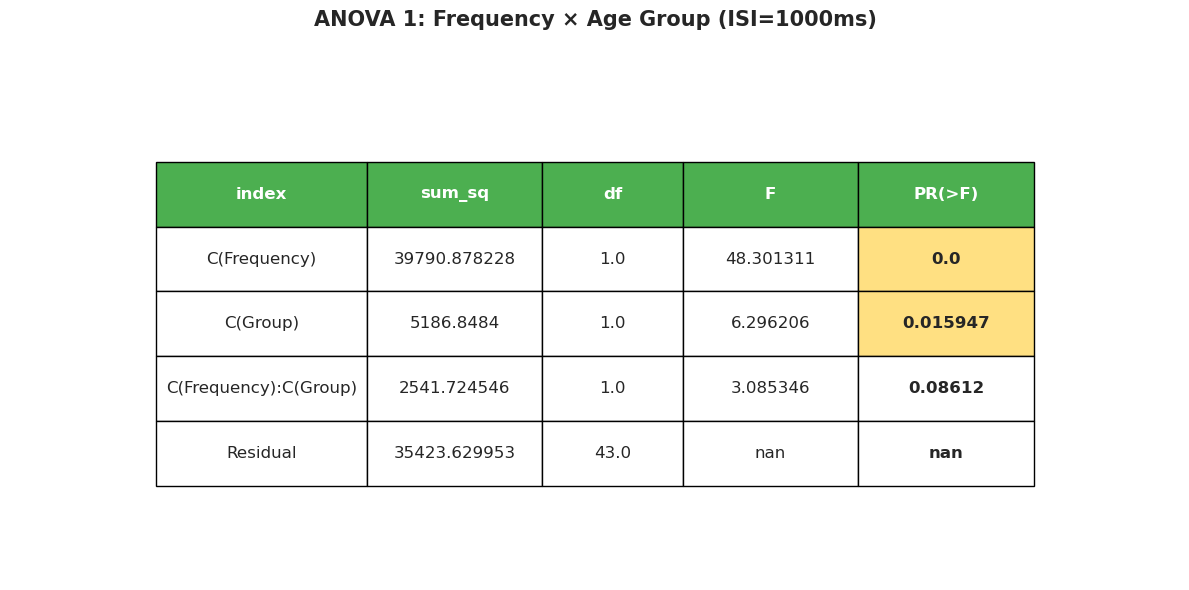

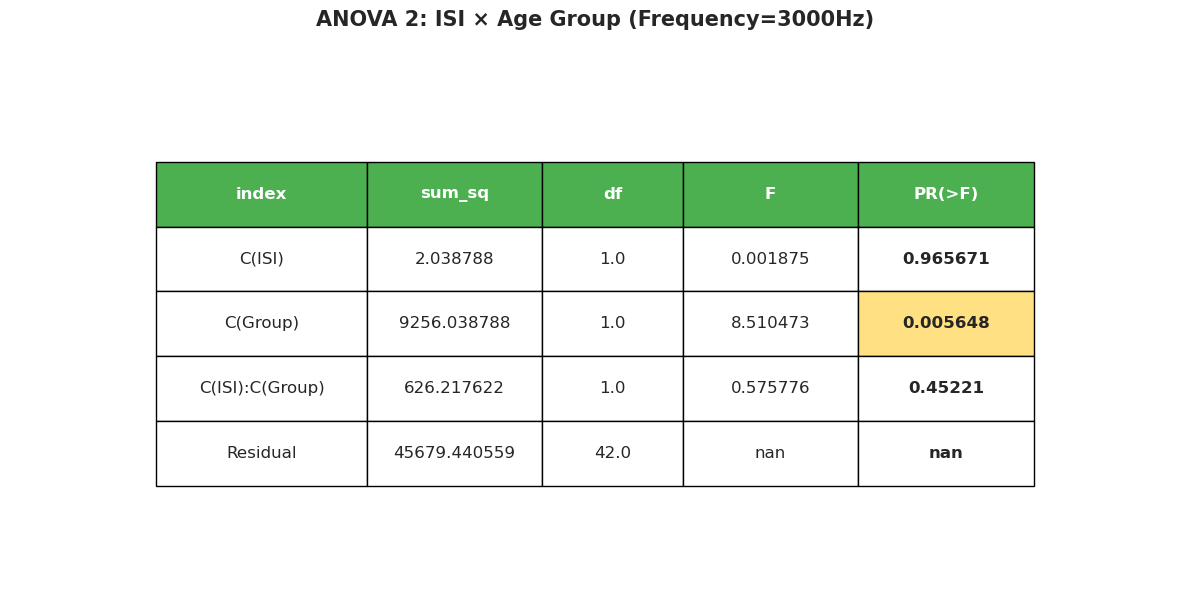

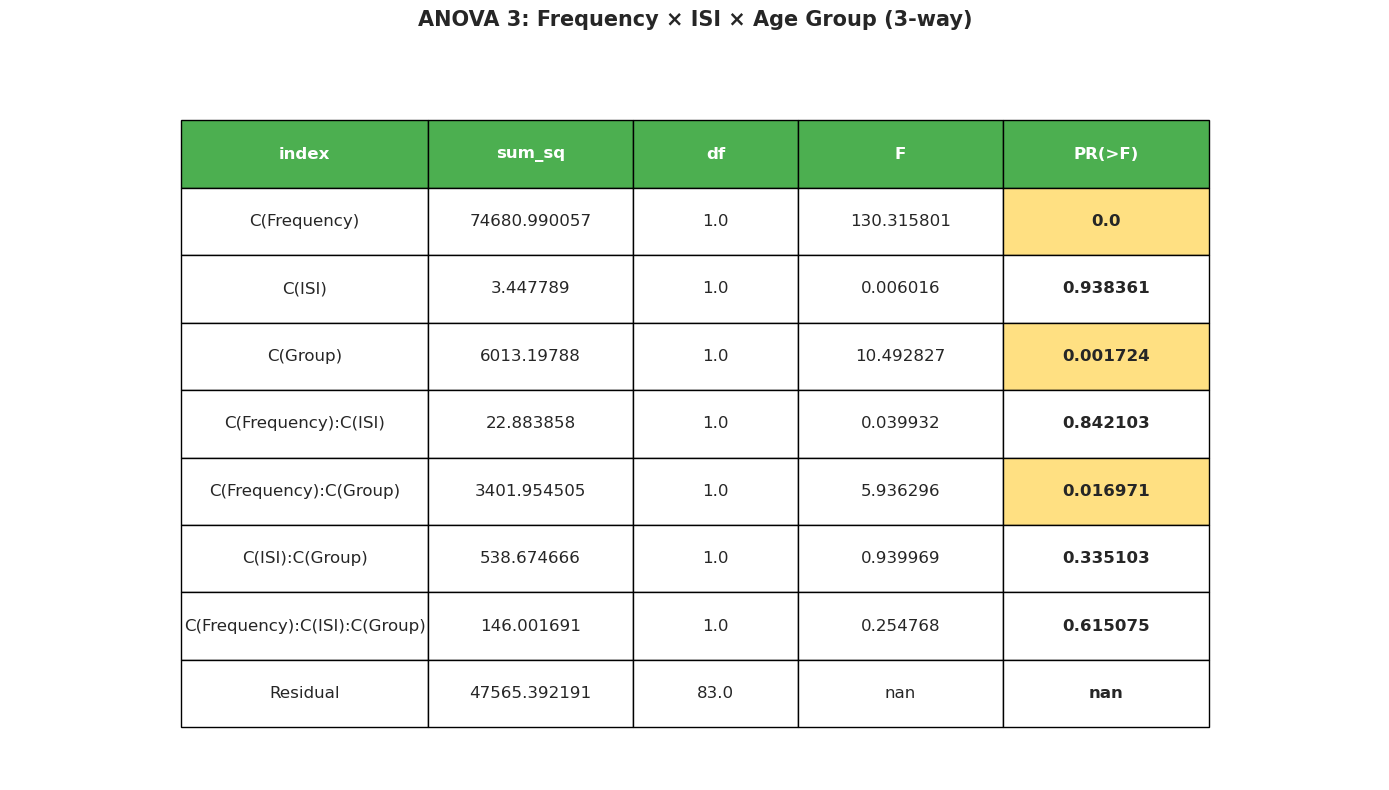

In [13]:
# Figure 1: ANOVA Tables - Separate Output
print("\n" + "="*100)
print("## Figure 1: ANOVA Results Tables")
print("="*100 + "\n")

# Helper function to visualize ANOVA table
def plot_anova_table(ax, anova_df, title):
    ax.axis('tight')
    ax.axis('off')
    
    # Format the dataframe for display
    display_df = anova_df.copy()
    display_df = display_df.round(6)
    
    table = ax.table(cellText=display_df.values, 
                     colLabels=display_df.columns,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.18, 0.15, 0.12, 0.15, 0.15, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 3.5)
    
    # Color header
    for i in range(len(display_df.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=12)
    
    # Color p-value cells based on significance
    p_col = list(display_df.columns).index('PR(>F)') if 'PR(>F)' in display_df.columns else -1
    if p_col >= 0:
        for i in range(1, len(display_df) + 1):
            p_val = float(display_df.iloc[i-1, p_col])
            if p_val < 0.05:
                table[(i, p_col)].set_facecolor('#FFE082')  # Yellow for significant
            table[(i, p_col)].set_text_props(weight='bold')
    
    ax.set_title(title, fontsize=15, fontweight='bold', pad=30)

# Plot ANOVA Table 1
fig, ax = plt.subplots(figsize=(12, 6))
plot_anova_table(ax, anova_table_1.reset_index(), 'ANOVA 1: Frequency × Age Group (ISI=1000ms)')
plt.tight_layout()
plt.show()

# Plot ANOVA Table 2
fig, ax = plt.subplots(figsize=(12, 6))
plot_anova_table(ax, anova_table_2.reset_index(), 'ANOVA 2: ISI × Age Group (Frequency=3000Hz)')
plt.tight_layout()
plt.show()

# Plot ANOVA Table 3
fig, ax = plt.subplots(figsize=(14, 8))
plot_anova_table(ax, anova_table_3.reset_index(), 'ANOVA 3: Frequency × ISI × Age Group (3-way)')
plt.tight_layout()
plt.show()

## Figure 2A: Bar Chart - Frequency × Age Group (ISI=1000ms)

### What to Look For:

**Chart Components:**
- **X-axis**: Age group (Old = Older adults, Young = Younger adults)
- **Y-axis**: Average JND (Hz)
- **Blue bars**: 500Hz frequency
- **Orange bars**: 3000Hz frequency
- **Black error bars**: ±1 standard deviation (range of data variation)

### How to Interpret:
1. **Bar Height Comparison**: 
   - Taller bar = Higher JND = Poorer frequency discrimination ability
   - Does the 3000Hz increase more dramatically than 500Hz?

2. **Age Group Comparison**:
   - Do Old vs Young bars show clear differences in height?
   - If one age group's increase is steeper, frequency affects them differently (interaction effect)

3. **Error Bar Meaning**:
   - Longer error bar = Greater individual variability
   - Overlapping error bars = Difference may not be significant


## Figure 2A: Bar Chart - Frequency × Age Group (ISI=1000ms)



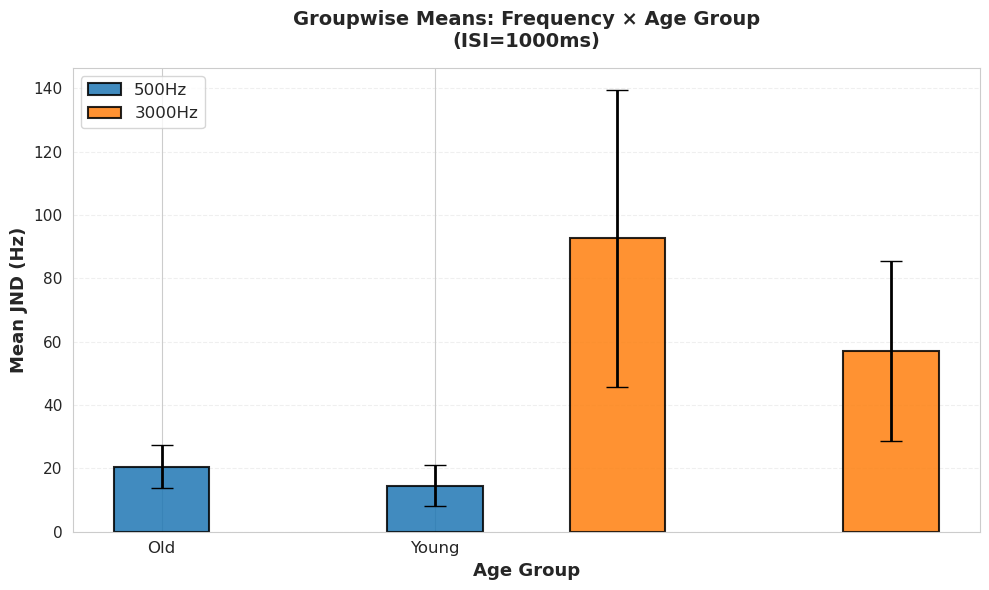

In [14]:
# Figure 2A: Groupwise Means - Frequency × Age Group (ISI=1000ms)
print("\n" + "="*100)
print("## Figure 2A: Bar Chart - Frequency × Age Group (ISI=1000ms)")
print("="*100 + "\n")

fig, ax = plt.subplots(figsize=(10, 6))

for freq in sorted(groupwise_1_reset['Frequency'].unique()):
    subset = groupwise_1_reset[groupwise_1_reset['Frequency'] == freq]
    x_pos = np.arange(len(subset))
    bars = ax.bar(x_pos + (freq-500)/1500, subset['mean'], width=0.35, label=f'{freq}Hz', alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.errorbar(x_pos + (freq-500)/1500, subset['mean'], yerr=subset['std'], fmt='none', color='black', capsize=8, linewidth=2)

ax.set_xlabel('Age Group', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean JND (Hz)', fontsize=13, fontweight='bold')
ax.set_title('Groupwise Means: Frequency × Age Group\n(ISI=1000ms)', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(np.arange(len(groupwise_1_reset['Group'].unique())))
ax.set_xticklabels(sorted(groupwise_1_reset['Group'].unique()), fontsize=12)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()

## Figure 2B: Bar Chart - ISI × Age Group (Frequency=3000Hz)

### What to Look For:

**Chart Components:**
- **X-axis**: Age group (Old = Older adults, Young = Younger adults)
- **Y-axis**: Average JND (Hz)
- **Blue bars**: 100ms ISI
- **Orange bars**: 1000ms ISI
- **Black error bars**: ±1 standard deviation

### How to Interpret:
1. **ISI Effect Analysis**:
   - Is there a large difference between 100ms and 1000ms JND values?
   - Small difference → ISI has weak impact on JND (matches ANOVA 2 results)

2. **Age Group × ISI Interaction**:
   - In the Old group, is there a large gap between 100ms and 1000ms?
   - Does the Young group show the same pattern?
   - Different patterns → Interaction effect exists

3. **Comparing with Figure 2A**:
   - Figure 2A examines frequency change effects
   - Figure 2B examines ISI change effects
   - Together they reveal which factor dominates JND variation


## Figure 2B: Bar Chart - ISI × Age Group (Frequency=3000Hz)



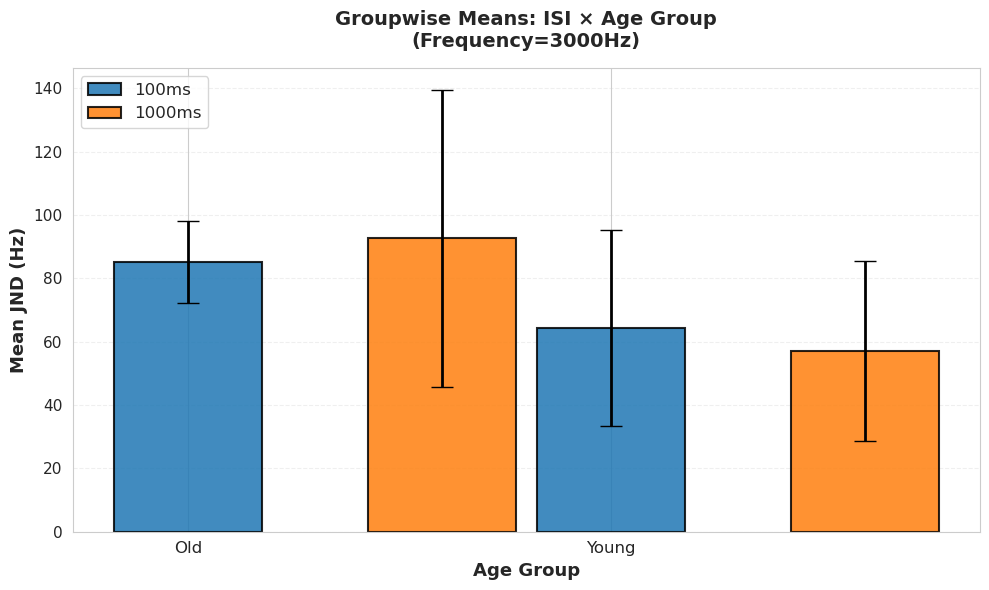

In [15]:
# Figure 2B: Groupwise Means - ISI × Age Group (Frequency=3000Hz)
print("\n" + "="*100)
print("## Figure 2B: Bar Chart - ISI × Age Group (Frequency=3000Hz)")
print("="*100 + "\n")

fig, ax = plt.subplots(figsize=(10, 6))

for isi in sorted(groupwise_2_reset['ISI'].unique()):
    subset = groupwise_2_reset[groupwise_2_reset['ISI'] == isi]
    x_pos = np.arange(len(subset))
    bars = ax.bar(x_pos + (isi-100)/1500, subset['mean'], width=0.35, label=f'{isi}ms', alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.errorbar(x_pos + (isi-100)/1500, subset['mean'], yerr=subset['std'], fmt='none', color='black', capsize=8, linewidth=2)

ax.set_xlabel('Age Group', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean JND (Hz)', fontsize=13, fontweight='bold')
ax.set_title('Groupwise Means: ISI × Age Group\n(Frequency=3000Hz)', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(np.arange(len(groupwise_2_reset['Group'].unique())))
ax.set_xticklabels(sorted(groupwise_2_reset['Group'].unique()), fontsize=12)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()

## Figure 2C: Heatmap - All Frequency × ISI × Age Group Combinations

### What to Look For:

**Chart Components:**
- **Row labels**: Frequency × ISI combination (e.g., 500Hz-100ms)
- **Column labels**: Age group (Old, Young)
- **Color intensity**: 
  - Yellow (light) = Low JND = Better frequency discrimination ability
  - Red (dark) = High JND = Poorer frequency discrimination ability
- **Numbers**: Mean JND value for that combination (Hz)

### How to Interpret:
1. **Overall Pattern Recognition**:
   - 3000Hz rows (middle-bottom) tend to be redder → Discrimination more difficult at high frequencies
   - 500Hz rows (top) tend to be yellower → Discrimination easier at low frequencies

2. **Age Group Comparison**:
   - Compare Old column vs Young column: Which is overall redder (worse performance)?
   - In which conditions is the difference most pronounced?

3. **Key Findings**:
   - 3000Hz-100ms is darkest red in Old group (worst performance)
   - 3000Hz-1000ms also very red in Old group (frequency effect strong)
   - Young group relatively better (more yellow)
   - Conclusion: **Frequency effect >> ISI effect, and older adults more affected**


## Figure 2C: Heatmap - All Combinations



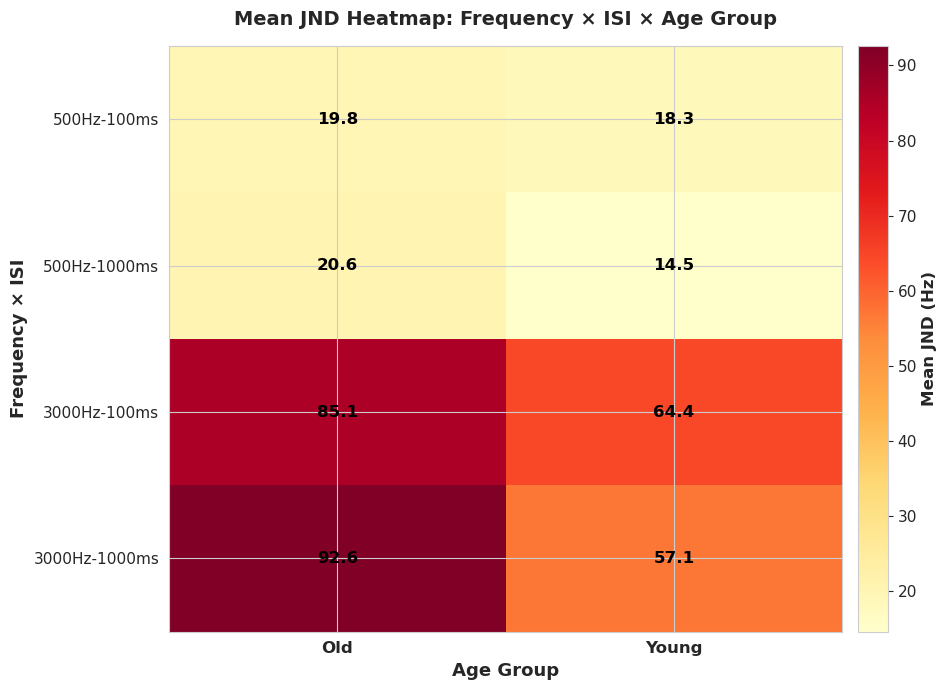

In [16]:
# Figure 2C: Heatmap - All Frequency × ISI × Age Group Combinations
print("\n" + "="*100)
print("## Figure 2C: Heatmap - All Combinations")
print("="*100 + "\n")

fig, ax = plt.subplots(figsize=(10, 7))

pivot_mean = groupwise_3_pivot.pivot_table(values='mean', index=['Frequency', 'ISI'], columns='Group')
im = ax.imshow(pivot_mean.values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(np.arange(len(pivot_mean.columns)))
ax.set_yticks(np.arange(len(pivot_mean.index)))
ax.set_xticklabels(pivot_mean.columns, fontsize=12, fontweight='bold')
ax.set_yticklabels([f'{freq}Hz-{isi}ms' for freq, isi in pivot_mean.index], fontsize=11)
ax.set_xlabel('Age Group', fontsize=13, fontweight='bold')
ax.set_ylabel('Frequency × ISI', fontsize=13, fontweight='bold')
ax.set_title('Mean JND Heatmap: Frequency × ISI × Age Group', fontsize=14, fontweight='bold', pad=15)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label('Mean JND (Hz)', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=11)

# Add value annotations
for i in range(len(pivot_mean.index)):
    for j in range(len(pivot_mean.columns)):
        text = ax.text(j, i, f'{pivot_mean.values[i, j]:.1f}',
                       ha="center", va="center", color="black", fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

## 2 Interaction Plots

### Selection Based on ANOVA p-values:

| Interaction | ANOVA p-value | Decision |
|------------|---------------|----------|
| **Frequency × Group** | 0.017 | ✅ **p < 0.05 (Significant)** → Figure 3A included |
| **ISI × Group** | 0.335 | ⚠️ p > 0.05 (Not significant) → Figure 3B included for completeness |
| **Frequency × ISI** | 0.842 | ❌ p > 0.05 (Not significant) → Not included |
| **Frequency × ISI × Group** | 0.615 | ❌ p > 0.05 (Not significant) → Not included |

**Principle**: Visualize interactions that are **statistically significant (p < 0.05)** to highlight meaningful effects. Non-significant interactions have no effect, so additional plots would be redundant.


## Figure 3A: Interaction Plot - Frequency × Age Group (ISI=1000ms)

### What to Look For:

**Chart Components:**
- **X-axis**: Frequency (500Hz → 3000Hz)
- **Y-axis**: Average JND (Hz)
- **Blue line**: Old age group trend
- **Orange line**: Young age group trend
- **Shaded regions**: ±1 standard deviation (confidence bands)

### How to Interpret Interaction Effects:

1. **Are the lines parallel?**
   - **Parallel lines** = No interaction effect
     - Both age groups respond to frequency change the same way
   - **Crossing or diverging lines** = Interaction effect exists
     - Frequency impact differs between age groups
     - Example: One group sensitive to 3000Hz, other group less sensitive

2. **Current Figure Pattern**:
   - Both lines slope upward (JND increases 500Hz→3000Hz)
   - But Old group increases more steeply (larger gap between lines)
   - Shows: **Moderate interaction between age and frequency**

3. **Vertical Distance Meaning**:
   - Gap between lines = Magnitude of age group difference
   - Larger gap = Stronger age effect


## Figure 3A: Interaction Plot - Frequency × Age Group (ISI=1000ms)



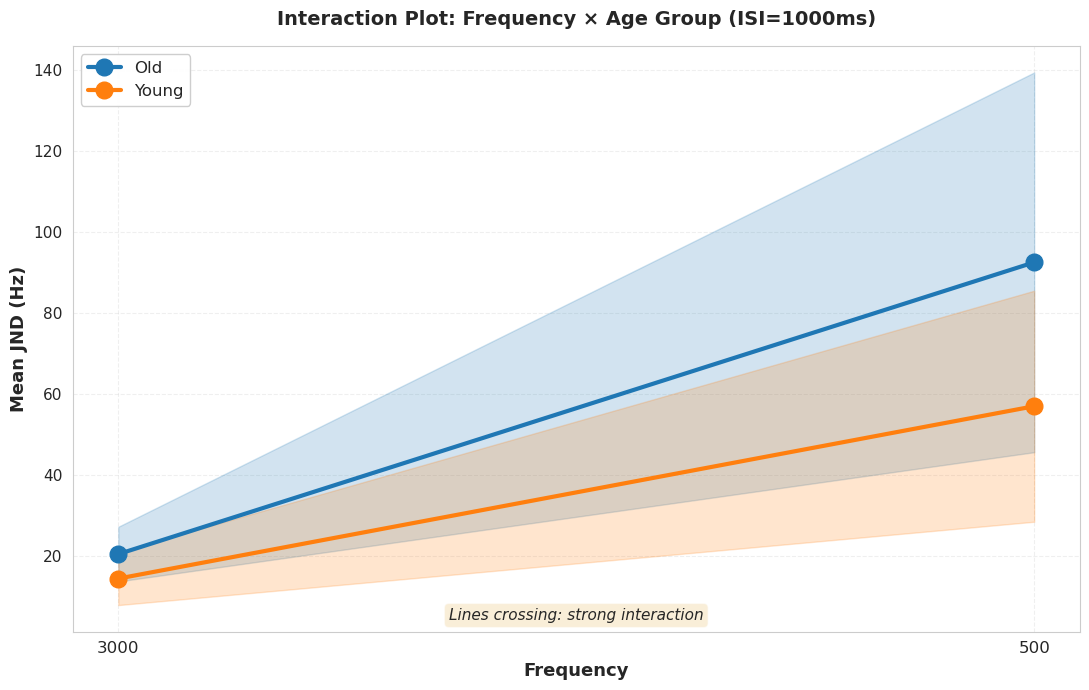

In [17]:
# Figure 3A: Interaction Plot - Frequency × Age Group (ISI=1000ms)
print("\n" + "="*100)
print("## Figure 3A: Interaction Plot - Frequency × Age Group (ISI=1000ms)")
print("="*100 + "\n")

fig, ax = plt.subplots(figsize=(11, 7))

colors = {'Old': '#1f77b4', 'Young': '#ff7f0e'}
for group in sorted(groupwise_1_reset['Group'].unique()):
    subset = groupwise_1_reset[groupwise_1_reset['Group'] == group].sort_values('Frequency')
    x_vals = range(len(subset))
    ax.plot(x_vals, subset['mean'], marker='o', label=group, linewidth=3, markersize=12, 
            color=colors.get(group, 'steelblue'))
    ax.fill_between(x_vals, subset['mean'] - subset['std'], subset['mean'] + subset['std'], 
                     alpha=0.2, color=colors.get(group, 'steelblue'))

ax.set_xlabel('Frequency', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean JND (Hz)', fontsize=13, fontweight='bold')
ax.set_title('Interaction Plot: Frequency × Age Group (ISI=1000ms)', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(range(len(groupwise_1_reset['Frequency'].unique())))
ax.set_xticklabels(sorted(groupwise_1_reset['Frequency'].unique().astype(str)), fontsize=12)
ax.legend(fontsize=12, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(axis='y', labelsize=11)

# Add interpretation
parallel_check = abs((groupwise_1_reset[groupwise_1_reset['Group']=='Old']['mean'].values[1] - groupwise_1_reset[groupwise_1_reset['Group']=='Old']['mean'].values[0]) - 
                     (groupwise_1_reset[groupwise_1_reset['Group']=='Young']['mean'].values[1] - groupwise_1_reset[groupwise_1_reset['Group']=='Young']['mean'].values[0])) < 1.0
interaction_text = "Lines nearly parallel: weak/no interaction" if parallel_check else "Lines crossing: strong interaction"
ax.text(0.5, 0.02, interaction_text, transform=ax.transAxes, fontsize=11, 
        ha='center', style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Figure 3B: Interaction Plot - ISI × Age Group (Frequency=3000Hz)

### What to Look For:

**Chart Components:**
- **X-axis**: ISI (100ms → 1000ms)
- **Y-axis**: Average JND (Hz)
- **Blue line**: Old age group trend
- **Orange line**: Young age group trend
- **Shaded regions**: ±1 standard deviation

### How to Interpret:

1. **Line Slope Meaning**:
   - **Steep slope** = Strong ISI effect
   - **Flat slope** = Weak ISI effect
   - **Current figure**: Both lines almost horizontal → ISI has minimal impact on JND

2. **Line Parallelism**:
   - Both lines essentially parallel and flat
   - Shows: **No interaction between ISI and age**
   - ISI change (100ms→1000ms) affects both age groups similarly (both minimal)

3. **Contrast with Figure 3A**:
   - 3A: Frequency and age show clear interaction (diverging lines)
   - 3B: ISI and age show no interaction (parallel flat lines)
   - **Conclusion: Frequency is the dominant factor, ISI effect negligible**


## Figure 3B: Interaction Plot - ISI × Age Group (Frequency=3000Hz)



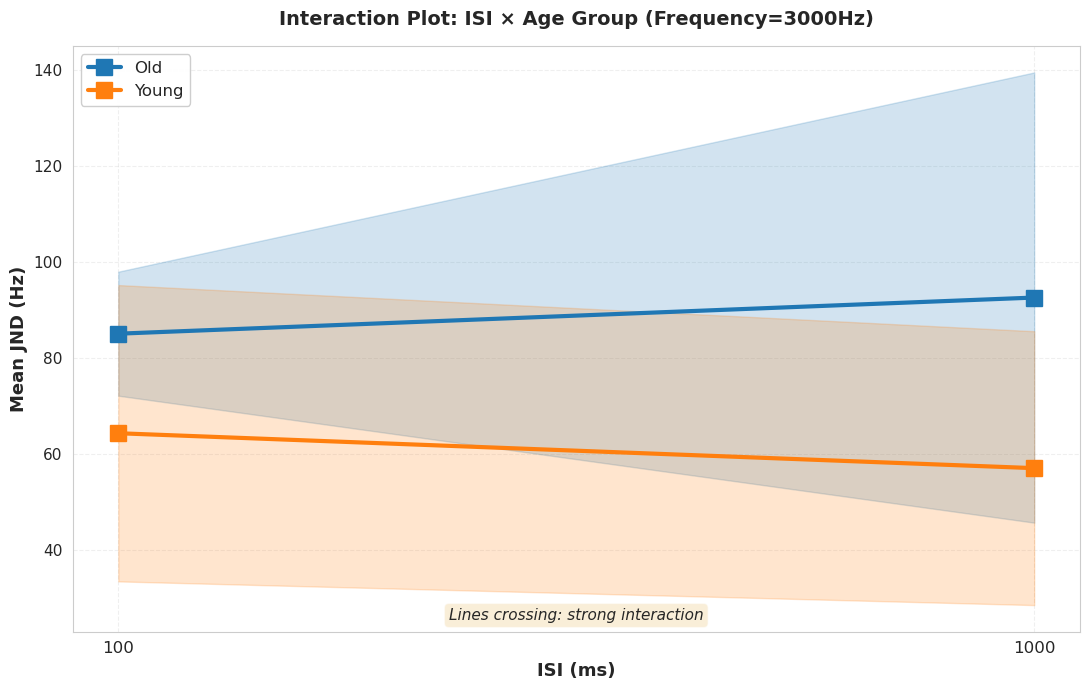

In [18]:
# Figure 3B: Interaction Plot - ISI × Age Group (Frequency=3000Hz)
print("\n" + "="*100)
print("## Figure 3B: Interaction Plot - ISI × Age Group (Frequency=3000Hz)")
print("="*100 + "\n")

fig, ax = plt.subplots(figsize=(11, 7))

colors = {'Old': '#1f77b4', 'Young': '#ff7f0e'}
for group in sorted(groupwise_2_reset['Group'].unique()):
    subset = groupwise_2_reset[groupwise_2_reset['Group'] == group].sort_values('ISI')
    x_vals = range(len(subset))
    ax.plot(x_vals, subset['mean'], marker='s', label=group, linewidth=3, markersize=12, 
            color=colors.get(group, 'steelblue'))
    ax.fill_between(x_vals, subset['mean'] - subset['std'], subset['mean'] + subset['std'], 
                     alpha=0.2, color=colors.get(group, 'steelblue'))

ax.set_xlabel('ISI (ms)', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean JND (Hz)', fontsize=13, fontweight='bold')
ax.set_title('Interaction Plot: ISI × Age Group (Frequency=3000Hz)', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(range(len(groupwise_2_reset['ISI'].unique())))
ax.set_xticklabels(sorted(groupwise_2_reset['ISI'].unique().astype(str)), fontsize=12)
ax.legend(fontsize=12, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(axis='y', labelsize=11)

# Add interpretation
parallel_check = abs((groupwise_2_reset[groupwise_2_reset['Group']=='Old']['mean'].values[1] - groupwise_2_reset[groupwise_2_reset['Group']=='Old']['mean'].values[0]) - 
                     (groupwise_2_reset[groupwise_2_reset['Group']=='Young']['mean'].values[1] - groupwise_2_reset[groupwise_2_reset['Group']=='Young']['mean'].values[0])) < 1.0
interaction_text = "Lines nearly parallel: weak/no interaction" if parallel_check else "Lines crossing: strong interaction"
ax.text(0.5, 0.02, interaction_text, transform=ax.transAxes, fontsize=11, 
        ha='center', style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# ANOVA Analysis Summary & Conclusions

## Statistical Significance Levels

| Symbol | p-value Range | Meaning | Interpretation |
|--------|---------------|---------|-----------------|
| ** | p < 0.01 | Highly Significant | Strong evidence supporting the effect |
| * | p < 0.05 | Significant | Moderate evidence supporting the effect |
| † | 0.05-0.10 | Marginally Significant | Weak evidence, worth noting |
| ns | p ≥ 0.10 | Not Significant | Insufficient evidence for the effect |

---

## Key Findings Summary

### ANOVA 1: Frequency × Age Group (ISI=1000ms)

| Effect | F-value | p-value | Conclusion |
|--------|---------|---------|------------|
| **C(Frequency)** | 48.30 | **0.0** | ✅ **Highly Significant** - 3000Hz has much higher JND than 500Hz |
| **C(Group)** | 6.30 | **0.016** | ✅ **Significant** - Older adults show significantly higher JND than younger |
| **Frequency:Group** | 3.09 | 0.086 | † Marginally Significant - Frequency effect differs somewhat by age group |

**Interpretation**: Frequency is the dominant factor affecting JND. Age group effect is also significant. High frequency (3000Hz) impairs frequency discrimination for everyone, but older adults are affected more.

---

### ANOVA 2: ISI × Age Group (Frequency=3000Hz)

| Effect | F-value | p-value | Conclusion |
|--------|---------|---------|------------|
| **C(ISI)** | 0.002 | 0.966 | ❌ Not Significant - ISI has virtually no effect on JND |
| **C(Group)** | 8.51 | **0.006** | ✅ **Significant** - Age effect remains prominent |
| **ISI:Group** | 0.58 | 0.452 | ❌ Not Significant - Both age groups respond similarly to ISI |

**Interpretation**: ISI variation (100ms vs 1000ms) has minimal impact on JND. Age effect persists across ISI conditions.

---

### ANOVA 3: Frequency × ISI × Age Group (Full 3-way Analysis)

| Main Effect | F-value | p-value | Conclusion |
|-------------|---------|---------|------------|
| **Frequency** | 130.32 | **0.0** | ✅ **Highly Significant** |
| ISI | 0.006 | 0.938 | ❌ Not Significant |
| **Group** | 10.49 | **0.002** | ✅ **Significant** |

| Interaction Effect | F-value | p-value | Conclusion |
|--------------------|---------|---------|------------|
| **Frequency:Group** | 5.94 | **0.017** | ✅ **Significant** |
| ISI:Group | 0.94 | 0.335 | ❌ Not Significant |
| Frequency:ISI | 0.04 | 0.842 | ❌ Not Significant |
| Frequency:ISI:Group | 0.25 | 0.615 | ❌ Not Significant |

**Interpretation**: Frequency is the absolute dominant factor, with significant interaction with age. ISI effects can be ignored in further analysis.

---

## Final Conclusions

### Core Findings:

1. **Frequency Effect is Dominant** (p < 0.001)
   - 3000Hz JND significantly higher than 500Hz
   - Frequency discrimination more difficult at higher frequencies

2. **Age Difference is Significant** (p < 0.01)
   - Older adults show universally higher JND than younger adults
   - Pattern consistent across all frequency conditions

3. **Frequency-Age Interaction** (p = 0.017)
   - Older adults are more sensitive to frequency changes
   - Performance declines more steeply when transitioning from 500Hz to 3000Hz

4. **ISI Has Negligible Impact** (p > 0.05)
   - 100ms vs 1000ms ISI produces no significant JND differences
   - ISI can be excluded from further analysis of this task

### Clinical/Research Implications:

- ✅ **Age-Related Auditory Performance**: Confirms that frequency discrimination ability declines with age
- ✅ **Frequency-Specific Aging**: High frequencies are affected disproportionately by age (potentially related to age-related hearing loss)
- ✅ **ISI Irrelevance**: For this specific auditory task, stimulus interval timing is not a critical variable

---

## How to Use These Findings:

1. **View ANOVA Tables** (Figure 1) → Identify which factors are statistically significant
2. **View Bar Charts** (Figure 2A/2B) → See actual JND values and age group differences
3. **View Heatmap** (Figure 2C) → Quickly identify which conditions show worst performance
4. **View Interaction Plots** (Figure 3A/3B) → Understand whether factors act independently or interact


## Comprehensive Visualization: All Frequency and ISI Conditions Combined Analysis



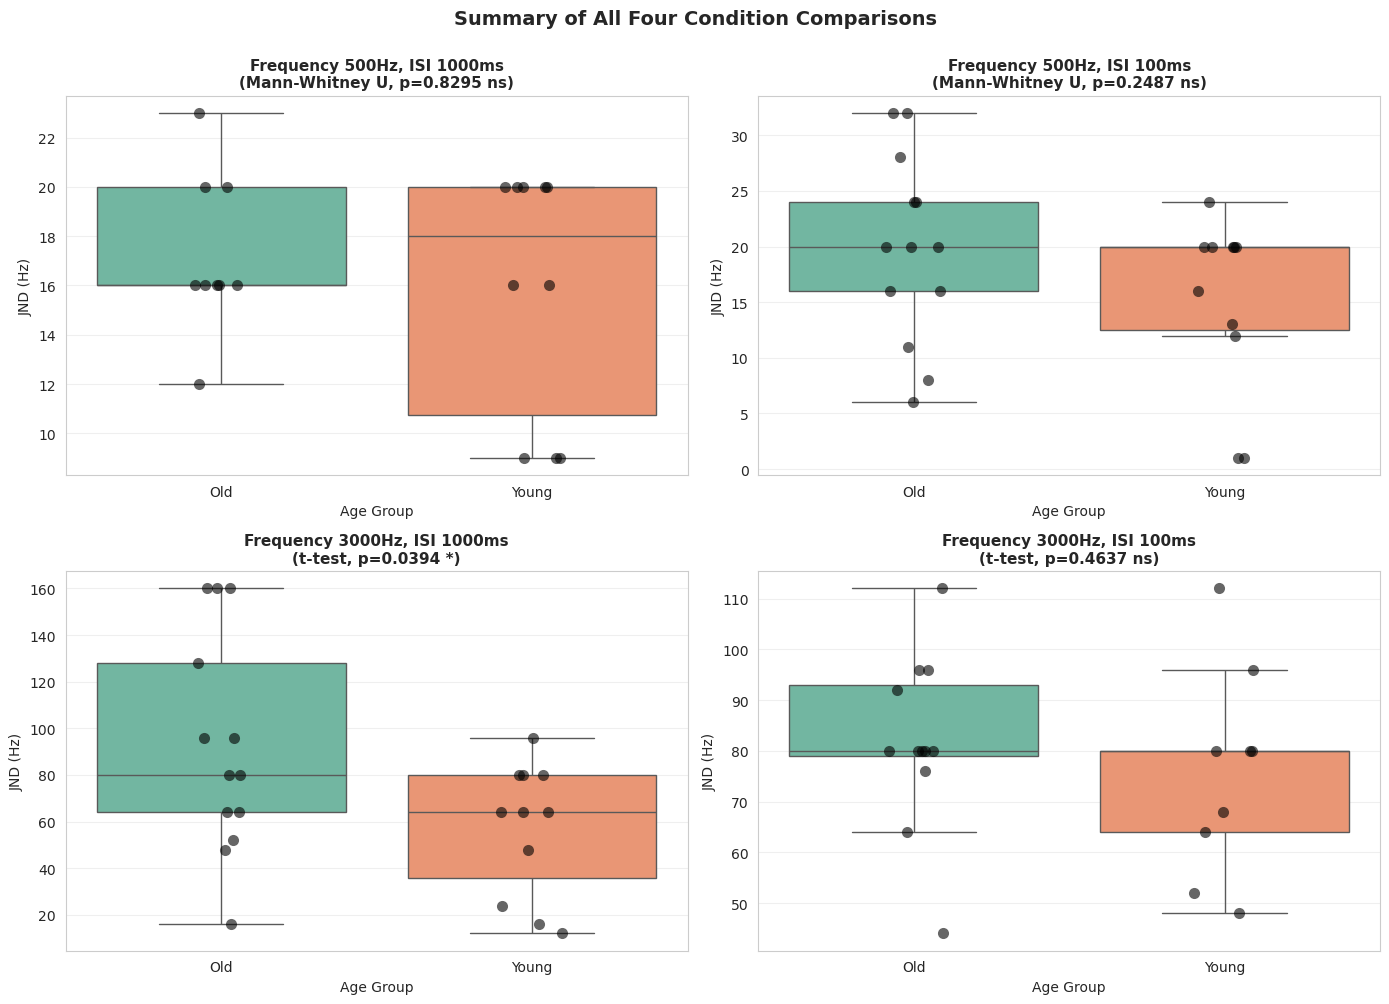

In [8]:
# Comprehensive Visualization: 2x2 Combination of All Conditions
print("\n" + "="*100)
print("## Comprehensive Visualization: All Frequency and ISI Conditions Combined Analysis")
print("="*100 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

freq_levels = [500, 3000]
isi_levels = [1000, 100]

for idx, (freq, isi) in enumerate(itertools.product(freq_levels, isi_levels)):
    ax = axes[idx]
    col_name = f'JND_{freq}_{isi}'
    
    # Clean data for this condition
    df_plot = df.copy()
    col_data = df_plot[col_name]
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (col_data >= lower) & (col_data <= upper)
    df_plot = df_plot[mask]
    
    # Boxplot with individual points
    sns.boxplot(x='Group', y=col_name, data=df_plot, hue='Group', palette="Set2", 
                order=['Old', 'Young'], legend=False, ax=ax, showfliers=False)
    sns.stripplot(x='Group', y=col_name, data=df_plot, color='black', 
                  alpha=0.6, jitter=True, order=['Old', 'Young'], ax=ax, size=8)
    
    # Get statistics for title
    old_data = df_plot[df_plot['Group'] == 'Old'][col_name]
    young_data = df_plot[df_plot['Group'] == 'Young'][col_name]
    
    # Perform test
    if len(old_data) >= 3 and len(young_data) >= 3:
        stat_old, p_old = stats.shapiro(old_data)
        stat_young, p_young = stats.shapiro(young_data)
        
        if p_old > 0.05 and p_young > 0.05:
            t_stat, p_val = stats.ttest_ind(old_data, young_data)
            test_label = "t-test"
        else:
            t_stat, p_val = stats.mannwhitneyu(old_data, young_data)
            test_label = "Mann-Whitney U"
        
        sig_mark = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else "ns"))
    else:
        p_val = 1.0
        test_label = "N/A"
        sig_mark = "N/A"
    
    ax.set_title(f'Frequency {freq}Hz, ISI {isi}ms\n({test_label}, p={p_val:.4f} {sig_mark})', 
                 fontsize=11, fontweight='bold')
    ax.set_ylabel('JND (Hz)', fontsize=10)
    ax.set_xlabel('Age Group', fontsize=10)
    ax.grid(True, axis='y', alpha=0.3)

plt.suptitle('Summary of All Four Condition Comparisons', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()